# Connecting more dots

In the last notebook, we worked from plotting our GPS tracks using geopandas and folium. Then we used the coordinates in the first two points in the track to create a shapely LineString connecting them. In this notebook, the goal is to connect all the conesecutive pairs of points with a line segment.

In [1]:
%matplotlib inline
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import LineString
import folium

In [2]:
def add_markers(mapobj, gdf):
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.geometry.y, row.geometry.x])
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 2.5, 
                            fill = True,
                            fill_color = '#F50057',
                            fill_opacity = 0.75,
                            color = 'whitesmoke',
                            weight = 0.5).add_to(mapobj)
    return mapobj

In [3]:
gps = 'timemanager_test_data.shp'
tracks = gpd.GeoDataFrame.from_file(gps)
tracks = tracks[['track_se_1', 'ele', 'time', 'geometry']].copy()
tracks.head()

,track_se_1,ele,time,geometry
0,0,125.7,2017/12/29 21:42:18.000,POINT Z (-78.668663 35.787979 125.7)
1,1,125.6,2017/12/29 21:42:23.000,POINT Z (-78.668841 35.787985 125.6)
2,2,125.4,2017/12/29 21:42:25.000,POINT Z (-78.66897 35.788028 125.4)
3,3,125.2,2017/12/29 21:42:27.000,POINT Z (-78.669096 35.788059 125.2)
4,4,125.1,2017/12/29 21:42:29.000,POINT Z (-78.669222 35.788086 125.1)


In [4]:
f = folium.Figure(height = 400)
m = folium.Map([35.792809, -78.675724], zoom_start = 15, tiles='Cartodb dark_matter')
m.add_to(f)

add_markers(m, tracks)

In [5]:
def get_coords(gdf, i, geometry = 'geometry'):
    geom0 = gdf.loc[i, geometry]
    geom1 = gdf.loc[i + 1, geometry]
    x0, y0, x1, y1 = [geom0.x, geom0.y, geom1.x, geom1.y]
    return x0, y0, x1, y1

In [6]:
# Create empty DataFrame
df = pd.DataFrame(columns = ['id', 'geometry'])

In [7]:
# Get coords for start and end points
x0, y0, x1, y1 = get_coords(tracks, 0)
print(x0, y0, x1, y1)

-78.668663 35.787979 -78.668841 35.787985


In [8]:
# Create LineString from coordinates
def get_coords(gdf, i, geometry = 'geometry'):
    geom0 = gdf.loc[i, geometry]
    geom1 = gdf.loc[i + 1, geometry]
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    return LineString([start, end])

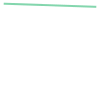

In [9]:
get_coords(tracks, 0)

In [10]:
# Add LineString to a DataFrame
def get_coords(gdf, df_out, i, geometry = 'geometry'):
    geom0 = gdf.loc[i, geometry]
    geom1 = gdf.loc[i + 1, geometry]
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    data = {'id': [0], 'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    df = pd.concat([df_out, df_line])
    return df

df_a = get_coords(tracks, df, 0)
df_a.head()

,id,geometry
0,0,"LINESTRING (-78.668663 35.787979, -78.668841 3..."


In [22]:
# Add LineString to a DataFrame
def make_line(gdf, df_out, i, geometry = 'geometry'):
    geom0 = gdf.loc[i, geometry]
    geom1 = gdf.loc[i + 1, geometry]
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    data = {'id': i, 'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    df_out = pd.concat([df_out, df_line])
    return df_out

df_output = pd.DataFrame(columns = ['id', 'geometry'])

x=0
while x < 3:
    df_input = make_line(tracks, df_output, x)
    df_output = df_input
    x = x + 1

df_output.head()

0   id                                           geometry
0  0  LINESTRING (-78.668663 35.787979, -78.668841 3...
1   id                                           geometry
0  0  LINESTRING (-78.668663 35.787979, -78.668841 3...
0  1  LINESTRING (-78.668841 35.787985, -78.66897 35...
2   id                                           geometry
0  0  LINESTRING (-78.668663 35.787979, -78.668841 3...
0  1  LINESTRING (-78.668841 35.787985, -78.66897 35...
0  2  LINESTRING (-78.66897 35.788028, -78.669096 35...


,id,geometry
0,0,"LINESTRING (-78.668663 35.787979, -78.668841 3..."
0,1,"LINESTRING (-78.668841 35.787985, -78.66897 35..."
0,2,"LINESTRING (-78.66897 35.788028, -78.669096 35..."


In [23]:
# Convert DataFrame to GeoDataFrame
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df_output, crs=crs)

folium.GeoJson(gdf).add_to(m)
m